In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import torch
torch.Tensor.ndim = property(lambda self: len(self.shape))
from sklearn.metrics import mean_squared_error

## Tobit

In [13]:
def tobit(y, y_hat, yL = 15, sigma=2):
    indicator = int(y < yL)
    return ((1/sigma * norm.pdf((y-y_hat)/sigma))**indicator) * (norm.cdf((y_hat - yL)/sigma))**(1-indicator)

In [14]:
y_hat = np.linspace(0.01, 50, num=100) # Embedding distance

In [15]:
L_pos = tobit(10, y_hat)
L_neg = tobit(50, y_hat)

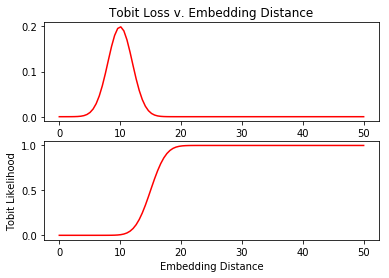

In [16]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

Thoughts: 
* Using embedding distances up to 50, but usually they are < 1. 

* Shouldn't the top graph be flipped upside down? If we try to minimize this, we will "push" away points > 10. 

* On the bottom graph, if a negative point is REALLY close, the gradient will be quite small right? The biggest gradient is actually until x = 25, which is the threshold. Is that ideal? It could also happen if sigma is not scaled large enough.





In [35]:
NUM_POINTS = 50
y_hat = np.linspace(1, 50, num=NUM_POINTS) # Embedding distance
y = np.linspace(1, 50, num=NUM_POINTS)     # GPS distance
tobit_likelihood = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    tobit_likelihood[i,:] = tobit(y[i], y_hat)

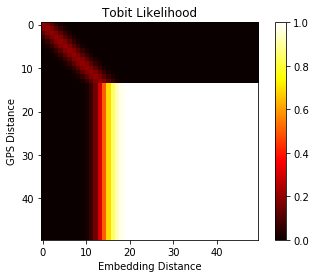

In [36]:
plt.imshow(tobit_likelihood, cmap='hot', interpolation='nearest')
plt.title('Tobit Likelihood')
plt.xlabel('Embedding Distance')
plt.ylabel('GPS Distance')
plt.colorbar()
plt.show()

- White area: High Likelihood
- Red/Yellow: Medium Likelihood
- Black area: Low Likelihood 

## Contrastive

In [48]:
# Original
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    return ((1-indicator) * 1/2 * y_hat**2) + indicator*1/2*((margin-y_hat).clip(min=0))**2

# Scaled up / down
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    y_hat *= 35
    margin_thr *= 35
    
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    y = ((1-indicator) * 1/2 * y_hat**2) + indicator*1/2*((margin-y_hat).clip(min=0))**2
    y /= (35**2)
    return y

In [49]:
NUM_POINTS = 1000
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances

In [50]:
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
L_Pos = contrastive(10, Dw)
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
L_Neg = contrastive(50, Dw)
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances

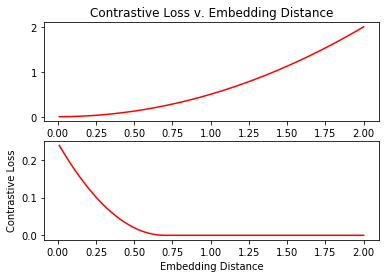

In [44]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Contrastive Loss v. Embedding Distance')
ax[0].plot(Dw, L_Pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Contrastive Loss')
ax[1].plot(Dw, L_Neg,'r-')

In [6]:
NUM_POINTS = 10
y_hat = np.linspace(1, 2, num=NUM_POINTS)- 1 # Embedding distance
y = np.linspace(0.001, 50, num=NUM_POINTS)   # GPS distance
contrastive_loss = np.ones((NUM_POINTS, NUM_POINTS))
print(y_hat)
for i in range(NUM_POINTS):
    contrastive_loss[i,:] = contrastive(y[i], y_hat)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


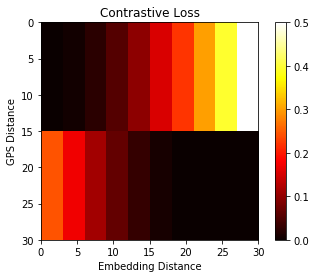

In [15]:
plt.imshow(contrastive_loss, cmap='hot', interpolation='nearest', extent=[0,30,30,0])
plt.colorbar()
plt.xlabel('Embedding Distance')
plt.ylabel('GPS Distance')
plt.title('Contrastive Loss')
plt.show()

## Scaled Contrastive

In [16]:
def scaled_contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    peak = margin_thr / yL * y
    return ((1-indicator)  * (y_hat - peak)**2) + indicator*0.5*((margin-y_hat).clip(min=0))**2
#4*lbl*torch.pow((D-peak_scaling),2) + 0.5*(1-lbl)*torch.pow(torch.clamp(margin-D, min=0),2)

In [17]:
NUM_POINTS = 1000
Dw = np.linspace(0.01, 1, num=NUM_POINTS) # Embedding Distances

In [18]:
L_Pos = scaled_contrastive(10, Dw)
L_Neg = scaled_contrastive(50, Dw)

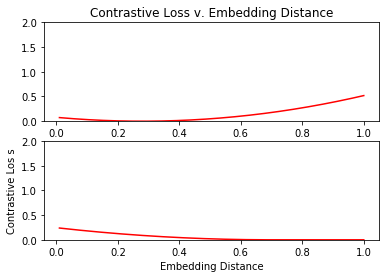

In [19]:
fig, ax = plt.subplots(2, 1)
ax[0].set_ylim(0, 2)
ax[0].set_title('Contrastive Loss v. Embedding Distance')
ax[0].plot(Dw, L_Pos,'r-')
ax[1].set_ylim(0, 2)
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Contrastive Los s')
ax[1].plot(Dw, L_Neg,'r-')

In [20]:
NUM_POINTS = 10
y_hat = np.linspace(1, 2, num=NUM_POINTS)- 1 # Embedding distance
y = np.linspace(0.001, 50, num=NUM_POINTS)   # GPS distance
contrastive_loss = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    contrastive_loss[i,:] = scaled_contrastive(y[i], y_hat)

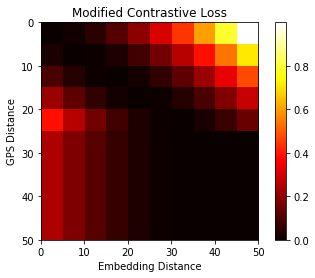

In [24]:
fig, ax = plt.subplots(1,1)
plt.imshow(contrastive_loss, cmap='hot', interpolation='nearest',  extent=[0, 50, 50, 0])
plt.title('Modified Contrastive Loss')
plt.xlabel('Embedding Distance')
plt.ylabel('GPS Distance')
plt.colorbar()
plt.show()

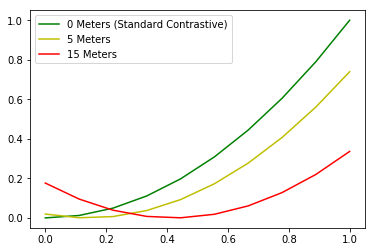

In [31]:
y_hat = np.linspace(1, 2, num=NUM_POINTS)- 1 # Embedding distance
fig, ax = plt.subplots(1,1)
L_pos = scaled_contrastive(0, y_hat)
ax.plot(y_hat,L_pos,'g-', label='0 Meters (Standard Contrastive)')
L_pos = scaled_contrastive(5, y_hat)
ax.plot(y_hat,L_pos,'y-', label='5 Meters')
L_pos = scaled_contrastive(15, y_hat)
ax.plot(y_hat,L_pos,'r-', label='15 Meters')
plt.legend()

## Triplet

In [342]:
def triplet_loss(dp, dn, margin=0.5):
    return (dp-dn+margin).clip(min=0)

In [343]:
triplet_loss(np.array([5,5]),np.array([4,4]))

array([1.5, 1.5])

In [344]:
NUM_POINTS = 10

In [345]:
dp = np.linspace(0.1, 2, num=NUM_POINTS)
dn = np.linspace(0.1, 2, num=NUM_POINTS)

In [346]:
triplet = np.ones((NUM_POINTS, NUM_POINTS))
for i, pos in enumerate(dp):
    dpi = np.full(NUM_POINTS, pos)
    triplet[i,:] = triplet_loss(dpi, dn)

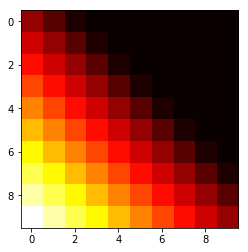

In [347]:
plt.imshow(triplet, cmap='hot', interpolation='nearest')
plt.show()

## Log Tobit

In [23]:
def log_tobit(y, y_hat, yL = 15, sigma=5):
    indicator = int(y < yL)
    #Tobit:       ((1/sigma * norm.pdf((y-y_hat)/sigma))**indicator) *     (norm.cdf((y_hat - yL)/sigma))**(1-indicator)
    return -np.log(1/sigma * norm.pdf((y-y_hat)/sigma))**indicator - np.log(norm.cdf((y_hat - yL)/sigma))**(1-indicator)

In [24]:
y_hat = np.linspace(0.01, 50, num=100) # Embedding distance
L_pos = log_tobit(10, y_hat)
L_neg = log_tobit(50, y_hat)

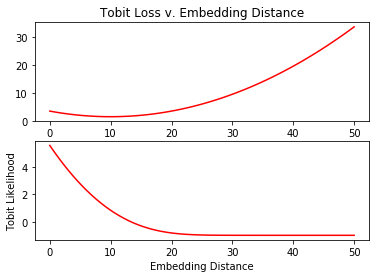

In [25]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

In [60]:
NUM_POINTS = 10
y_hat = np.linspace(1, 50, num=NUM_POINTS) # Embedding distance
y = np.linspace(1, 50, num=NUM_POINTS)     # GPS distance
tobit_likelihood = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    tobit_likelihood[i,:] = log_tobit(y[i], y_hat)

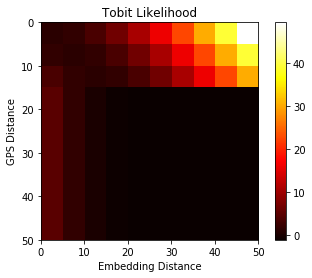

In [57]:
plt.imshow(tobit_likelihood, cmap='hot', interpolation='nearest',  extent=[0, 50, 50, 0])
plt.title('Tobit Likelihood')
plt.xlabel('Embedding Distance')
plt.ylabel('GPS Distance')
plt.colorbar()
plt.show()

### PyTorch 

In [10]:
import torch
import math

In [89]:
normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [90]:
torch.Tensor.ndim = property(lambda self: len(self.shape))

In [5]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/4):
    scaling = 1#/15
    indicator = int(y < yL)
    return -np.log(1/sigma) - normal.log_prob((y-y_hat)/sigma)*indicator - torch.log(normal.cdf((y_hat - yL)/sigma)) * (1-indicator)

In [91]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/4):
    scaling = 1 #/yL
    indicator = int(y < yL)
    if indicator == 1:
        return (np.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma))
    else:
        return -torch.log(normal.cdf((y_hat - yL*scaling)/sigma))

In [92]:
y_hat = torch.linspace(0.01, 2, steps=100) # Embedding distance
L_pos = log_tobit_torch(5, y_hat)
L_neg = log_tobit_torch(40, y_hat)

In [276]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/2):
    scaling = 1/yL
    #indicator = int(y < yL)
    indicator = torch.tensor([1.0,0.0,0.0,0.0,0.0,0.0])
    inv_indicator = torch.tensor([0,1.0,1.0,1.0,1.0,1.0])
    #if indicator == 1:
         #- (math.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma) *lbl)
    return - (math.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma)) * indicator #- torch.log(normal.cdf((y_hat - yL*scaling)/sigma)) * inv_indicator
    #return - (math.log(1/sigma) + normal.log_prob((y*scaling-y_hat)/sigma)*indicator) - torch.log(normal.cdf((y_hat - yL*scaling)/sigma)) * inv_indicator
    #else:
    #    return -torch.log(normal.cdf((y_hat - yL*scaling)/sigma))
    #return -np.log(1/sigma) - normal.log_prob((y-y_hat)/sigma)*indicator - torch.log(normal.cdf((y_hat - yL)/sigma)) * (1-indicator)

In [281]:
y = 14.206073
D = torch.tensor([0.7247, 0.8282, 0.6296, 0.6339, 0.6391, 0.6446])
#tensor([1.6438, 1.5458, 1.5452, 1.5432, 1.5408, 1.5383]

In [282]:
log_tobit_torch(y,D)

tensor([0.3247, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

tensor([10.1922,  9.8585,  9.5306,  9.2096,  8.8942,  8.5851,  8.2822,  7.9853,
         7.6945,  7.4098])


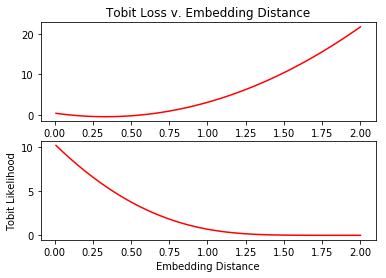

In [207]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')
print(L_neg[0:10])

In [24]:
sigma = 1
dist = 1
D = 1
lbl = 1
gpsmargin = 15
scaling = 1/15

In [25]:
normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
log_tobit = - (math.log(1/sigma) + normal.log_prob((dist*scaling-D)/sigma)*lbl) - torch.log(normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

TypeError: 'float' object cannot be interpreted as an integer

## CDF Loss 

In [5]:
def cdf(y, y_hat, yL = 15, sigma=1):
    indicator = int(y < yL)
    scaling = 1 /(yL * 2)
    return (norm.cdf((y_hat - yL*scaling)/sigma))**(indicator) * (1-norm.cdf((y_hat - yL*scaling)/sigma))**(1-indicator)

In [6]:
y_hat = np.linspace(0.01, 2, num=100) # Embedding distance
L_pos = cdf(10, y_hat)
L_neg = cdf(50, y_hat)

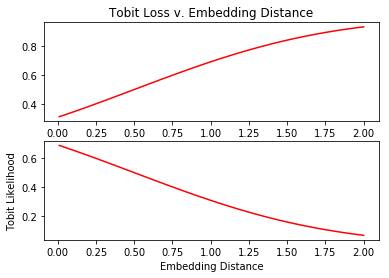

In [7]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

In [9]:
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    indicator = int(y > yL) # => Postive point
    margin = torch.empty(len(y_hat)).fill_(margin_thr)
    return ((1-indicator) * 1/2 * y_hat**2) + indicator*1/2*(torch.clamp(margin-y_hat, min=0))**2

In [372]:
def cdfloss1(D, lbl, gpsmargin=15, sigma=1):
    P_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    N_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.2]))
    scaling = 1/(gpsmargin * 4) 
    p_scaling = 1/gpsmargin
    return -torch.log(1-P_normal.cdf((D - gpsmargin*p_scaling)/sigma))*lbl - 1/10*torch.log(N_normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

def cdfloss(D, lbl, gpsmargin=15, sigma=1):
    P_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.7]))
    N_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.2]))
    scaling = 1/(gpsmargin * 4) 
    p_scaling = 1 /(gpsmargin * 8)
    gps_dist = 15
    return -(math.log(1/0.7) + P_normal.log_prob((p_scaling*gps_dist - D) / 0.7 ))*lbl - 1/10*torch.log(N_normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

#- (math.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma))

In [373]:
y_hat = torch.linspace(0.01, 0.5, steps=100)
lbl = torch.ones(100)
L_pos = cdfloss(y_hat, lbl)
L_pos_con = contrastive(1, y_hat)
lbl = torch.zeros(100)
L_neg = cdfloss(y_hat, lbl)
L_neg_con = contrastive(50, y_hat)

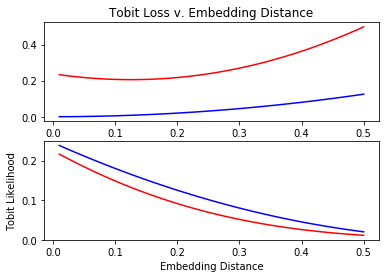

In [374]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[0].plot(y_hat,L_pos_con,'b-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')
ax[1].plot(y_hat, L_neg_con,'b-')

## Sigmoid 

In [145]:
def sigmoid(x, c1=10, c2=0.8):
    return 1 / (1+math.exp(-c1 * (x-c2)))

In [146]:
y_hat = np.linspace(0.01, 2, num=100) # Embedding distance
L = np.ones(100)
for i in range(100):
    L[i] = sigmoid(y_hat[i])

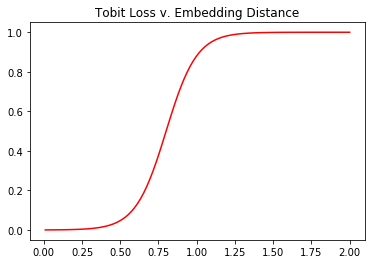

In [147]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Tobit Loss v. Embedding Distance')
ax.plot(y_hat,L,'r-')

In [3]:
y_hat = torch.linspace(0.01, 0.5, steps=100)
lbl = torch.ones(100)

In [4]:
def cdfloss1(D, lbl, dist = 1, gpsmargin=15, sigma=1):
    #if len(gps) > 0:
    #    dist = 1# distance(gps[0], gps[1])
    P_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.8]))
    N_normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.2]))

    n_scaling = 1/(gpsmargin * 4)
    p_scaling = 1/(gpsmargin * 4) #/(dist * 8)
    
    cdf = -(math.log(1/0.7) + P_normal.log_prob((D - dist*p_scaling)/0.7))*lbl - 1/10*torch.log(N_normal.cdf((D - gpsmargin*n_scaling)/sigma)) * (1-lbl)
    return cdf

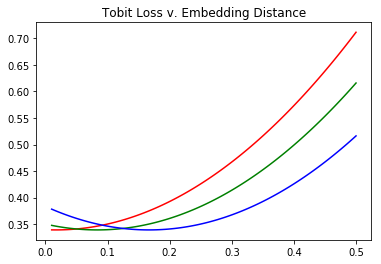

In [8]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Tobit Loss v. Embedding Distance')
L_pos = cdfloss1(y_hat, lbl, dist=1)
ax.plot(y_hat,L_pos,'r-')
L_pos = cdfloss1(y_hat, lbl, dist=5)
ax.plot(y_hat,L_pos,'g-')
L_pos = cdfloss1(y_hat, lbl, dist=10)
ax.plot(y_hat,L_pos,'b-')
plt.show()

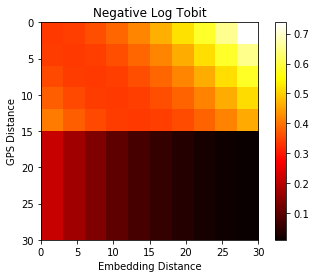

In [119]:
NUM_POINTS = 10
y_hat = torch.linspace(0.01, 0.5, steps=NUM_POINTS)
y = np.linspace(0.01, 30, num=NUM_POINTS) 
tobit_likelihood = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    #tobit_likelihood[i,:] = log_tobit(y[i], y_hat)
    #cdfloss1(y_hat, lbl, dist=y[i])
    lbl = 0
    if y[i] <= 15:
        lbl = 1
    tobit_likelihood[i,:] = cdfloss1(y_hat, lbl, dist=y[i])

plt.imshow(tobit_likelihood, cmap='hot', interpolation='nearest',  extent=[0, 30, 30, 0])
plt.title('Negative Log Tobit')
plt.xlabel('Embedding Distance')
plt.ylabel('GPS Distance')
plt.colorbar()
plt.show()

## GPS Scaled Tobit

In [10]:
def cdfloss(D, lbl, gps_dist = 5, gpsmargin=15, sigma=5.0):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    scaling = 55
    lbl = int(gps_dist < gpsmargin) # => Postive point
    return -(math.log(1/sigma) + normal.log_prob((gps_dist - D*scaling) / sigma ))*lbl - torch.log(normal.cdf((D*scaling - gpsmargin)/sigma)) * (1-lbl)


In [11]:
y_hat = torch.linspace(0.01, 0.5, steps=100)
lbl = torch.ones(100)
L_pos = cdfloss(y_hat, lbl, gps_dist=5)
L_pos_con = contrastive(1, y_hat)
lbl = torch.zeros(100)
L_neg = cdfloss(y_hat, lbl, gps_dist=50)
L_neg_con = contrastive(50, y_hat)

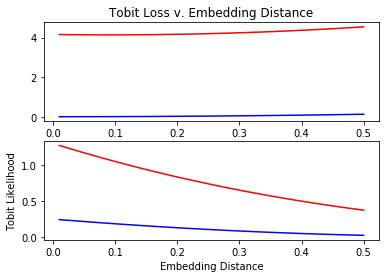

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[0].plot(y_hat,L_pos_con,'b-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')
ax[1].plot(y_hat, L_neg_con,'b-')

In [14]:
def cdfloss(D, gps_dist = 5, scaling = 200, gpsmargin=15, sigma=5.0):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    if gps_dist <= 50:
        return -(math.log(1/sigma) + normal.log_prob((gps_dist - D*scaling) / sigma))
    return - torch.log(normal.cdf((D*scaling - gpsmargin)/sigma))

In [19]:
def cdfloss1(D, gps_dist = 5, scaling = 200, gpsmargin=15, sigma=5.0, margin=0.7):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    lbl = int(gps_dist <= gpsmargin) # => Postive point321
            #lbl*(math.log(1/sigma) + normal.log_prob((dist - D*scaling) / sigma)) + 0.5*(1-lbl)*torch.pow(torch.clamp(margin-D, min=0),2)
    return -lbl*(math.log(1/sigma) + normal.log_prob((gps_dist - D*scaling) / sigma)) + 0.5*(1-lbl)*torch.pow(torch.clamp(margin-D, min=0),2)

In [63]:
def cdfloss1(D, gps_dist = 5, scaling = 200, gpsmargin=15, sigma=1.0, margin=0.7):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    lbl = int(gps_dist <= gpsmargin) # => Postive point
    return -lbl*(math.log(1/sigma) + normal.log_prob((dist*scaling - D) / sigma)) - torch.log(normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

In [64]:
#%matplotlib notebook

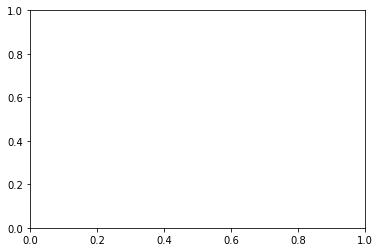

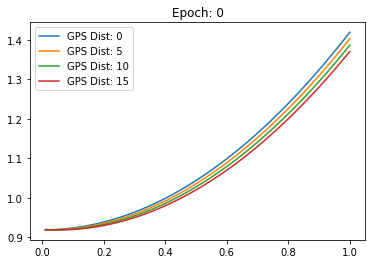

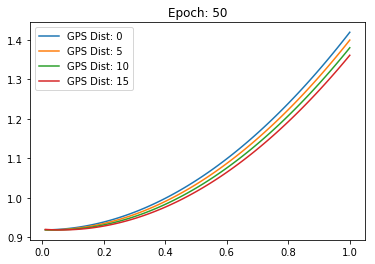

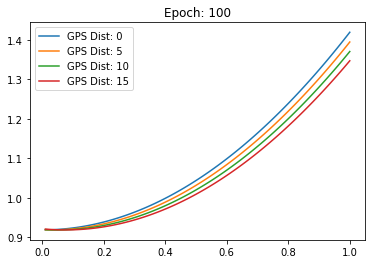

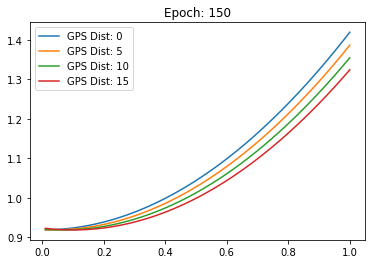

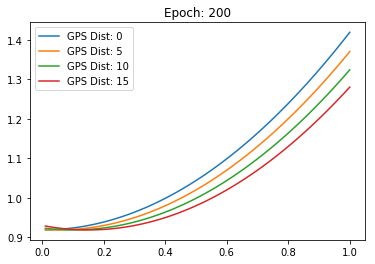

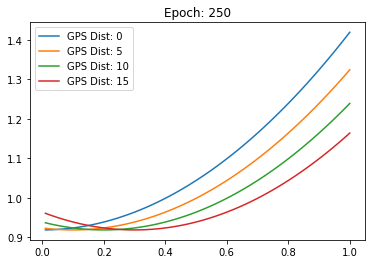

In [74]:
fig, ax = plt.subplots(1, 1)
y_hat = torch.linspace(0.01, 1, steps=100)

for epoch in range(0, 300, 50):
    fig, ax = plt.subplots(1, 1)
    for dist in range(0, 20, 5):
        L_pos = cdfloss1(y_hat, gps_dist=dist, scaling = 1/max(300 - epoch, 0))
        ax.plot(y_hat, L_pos, label=f'GPS Dist: {dist}')
        ax.set_title(f'Epoch: {epoch}')
        ax.legend()
        ax.plot()

In [261]:
def cdfloss(D, gps_dist = 5, scaling=100, gpsmargin=15, sigma=5.0):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    return -(math.log(1/sigma) + normal.log_prob(gps_dist/scaling))

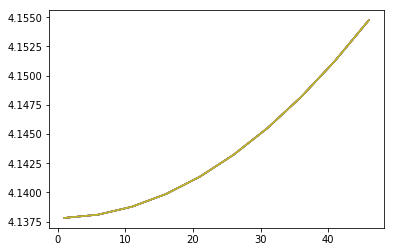

In [262]:
fig, ax = plt.subplots(1, 1)
y_hat = torch.linspace(0.01, 2, steps=100)

for scale in range(1, 10, 1):
    L_pos = []
    y_hat = []
    for dist in range(1, 50, 5):
        y_hat.append(dist)
        L_pos.append(cdfloss(y_hat, gps_dist=dist, scaling=50))
    ax.plot(y_hat, L_pos)

In [206]:
normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([5.0]))
normal.log_prob(0)

tensor([-2.5284])

In [184]:
# Scaled up / down
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    y_hat *= 35
    margin_thr *= 35
    
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    y = ((1-indicator) * 1/2 * y_hat**2) + indicator*1/2*((margin-y_hat).clip(min=0))**2
    y /= (35**2)
    return y

# Scaled up / down
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    beta = 0.5
    
    y_hat *= 35
    margin_thr *= 35
    
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    #loss = ((1-indicator) * 1/2 * y_hat**2) # Positive
    loss = (1-indicator) * beta * (y_hat - [y]*len(y_hat))**2
    loss += indicator*1/2*((margin-y_hat).clip(min=0))**2 # Negative
    loss /= (35**2)
    return loss

In [185]:
NUM_POINTS = 1000
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
L_Pos = contrastive(14, Dw)
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
L_Pos1 = contrastive(1, Dw)
                    
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
L_Neg = contrastive(50, Dw)

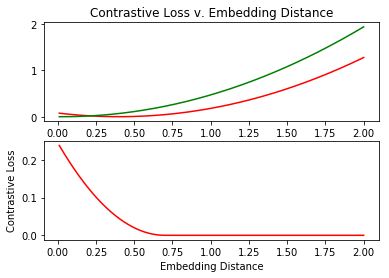

In [186]:
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances
fig, ax = plt.subplots(2, 1)

ax[0].set_title('Contrastive Loss v. Embedding Distance')
ax[0].plot(Dw, L_Pos,'r-')
ax[0].plot(Dw, L_Pos1,'g-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Contrastive Loss')
ax[1].plot(Dw, L_Neg,'r-')